In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import os
import time

# Dataset Preprocessing

Load Dataset

In [2]:
folder_dir = "/content/drive/MyDrive/Projects/CERN openlab Summer Student 2021/"

X_train = np.load(folder_dir + "dataset/optimal/x_data_optimal_norm_7.20e+05_train.npy")
y_train = np.load(folder_dir + "dataset/optimal/y_data_optimal_norm_7.20e+05_train.npy")
X_val = np.load(folder_dir + "dataset/optimal/x_data_optimal_norm_7.20e+05_valid.npy")
y_val = np.load(folder_dir + "dataset/optimal/y_data_optimal_norm_7.20e+05_valid.npy")
X_test = np.load(folder_dir + "dataset/optimal/x_data_optimal_norm_7.20e+05_test.npy")
y_test = np.load(folder_dir + "dataset/optimal/y_data_optimal_norm_7.20e+05_test.npy")

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1152000, 67) (1152000,)
Validation shape: (144000, 67) (144000,)
Test shape: (144000, 67) (144000,)


Take only the positive class (y = 1): the events which the Higgs are being produced, as we are not interested in reproducing the background data (for now).

In [3]:
X_train = X_train[y_train == 1]
X_val = X_val[y_val == 1]
X_test = X_test[y_test == 1]

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (576290, 67)
Validation shape: (71942, 67)
Test shape: (71768, 67)


In [4]:
a = X_train[X_train[:, 7] == 0]
a = a[a[:, 15] == 0]
a = a[a[:, 23] == 0]
a = a[a[:, 31] == 0]
a = a[a[:, 39] == 0]
a = a[a[:, 47] == 0]
a = a[a[:, 55] == 0]

len(a)

260

The 67 features in the dataset are arranged as follow:
$$
\text{1st jet, 2nd jet, 3rd jet, ..., 7th jet, MET, lepton}
$$
The jets in total have $7x8 = 56$ features, where every jet has 8 features, which are ordered as:
$$
\text{["pt", "eta", "phi", "en", "px", "py", "pz", "btag"]}
$$
MET has 4 features, which are ordered as:
$$
\text{"phi", "pt", "px", "py"]}
$$
lepton has 7 features, which are ordered as:
$$
\text{["pt", "eta", "phi", "en", "px", "py", "pz"]}
$$

Notes:
- MET = missing transverse momentum
- lepton = (electron or muon)
- btag = either 1 or 0, 1 means the jet is the b-jet, 0 otherwise

We then preprocess the training set so that the training set contains:

1. Only the two b-jets (jets with $\text{btag} = 1$) with the highest $\text{"pt"}$.
2. For every jets, only keep the $\text{"pt", "eta", "phi", "en"}$ features.

In total, the final training set should have $2x4 = 8$ features.

In [5]:
total_jets = 7  ## number of jets in the dataset
features_wanted = 8  ## number of features to be used during the training

selected_events = np.zeros((1, features_wanted))

for i in range (total_jets-1):
    for j in range(i+1, total_jets):
        index_temp = np.where(np.logical_and(X_train[:, 8*i + 7] == 1, X_train[:, 8*j + 7] == 1))[0]
        temp = np.concatenate((X_train[index_temp, 8*i:(8*i+4)], X_train[index_temp, 8*j:(8*j+4)]), axis=1)
        selected_events = np.concatenate((selected_events, temp), axis=0)
        print(i, j, len(temp))

        X_train = np.delete(X_train, index_temp, axis=0)

X_train = np.delete(selected_events, 0, axis=0)

X_train.shape

0 1 159667
0 2 83610
0 3 38949
0 4 17209
0 5 6790
0 6 2763
1 2 85366
1 3 42179
1 4 18801
1 5 7646
1 6 3090
2 3 39229
2 4 17406
2 5 7334
2 6 2889
3 4 15368
3 5 6354
3 6 2513
4 5 5342
4 6 2060
5 6 1670


(566235, 8)

# Data Visualization

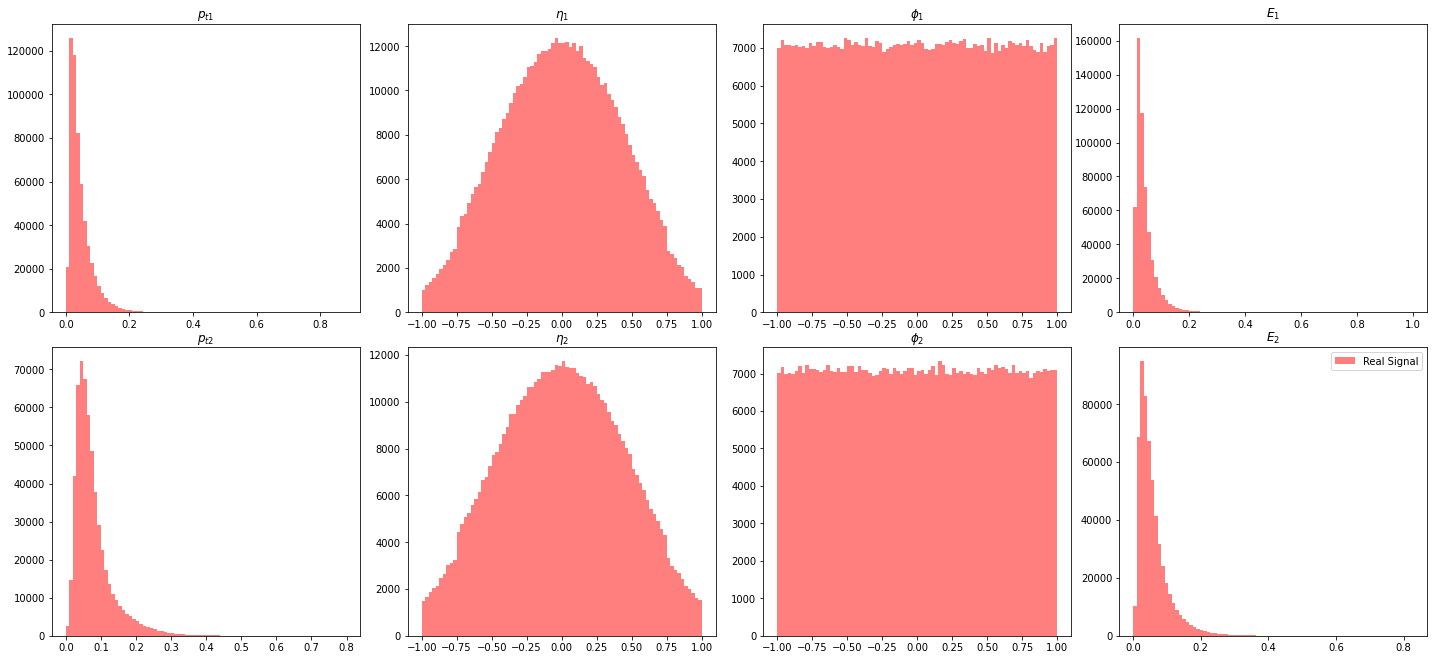

In [6]:
fig, ax = plt.subplots(2,4,figsize=(20, 10))
fig.tight_layout(pad=1.7)
plt.subplots_adjust(bottom=0.05, top=0.9)

features_name = ["$p_{t1}$","$\eta_{1}$","$\phi_{1}$","$E_{1}$","$p_{t2}$","$\eta_{2}$","$\phi_{2}$","$E_{2}$"]

for i in range(features_wanted):
    # real signal
    ax[int(i/4),i%4].hist(X_train[:,i],  alpha=0.5, color='r', label='Real Signal', bins=80)
    ax[int(i/4),i%4].title.set_text(features_name[i])

plt.legend()
plt.show()

# Model Set Up

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((8,8,2), input_shape=(128,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(1,1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(16, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, activation='tanh'))

    return model

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(128, input_shape=(8,)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((8,8,2)))

    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [9]:
input_vector = tf.random.uniform([len(X_train), 128], minval=0, maxval=1, seed=None)
input_vector.shape

TensorShape([566235, 128])

In [10]:
model_gen = make_generator_model()
fake_data = model_gen.predict(input_vector)
print(fake_data.shape)
#tf.keras.utils.plot_model(model_gen, rankdir='TB')

(566235, 8)


In [11]:
model_disc = make_discriminator_model()
print(model_disc(fake_data).shape)
#tf.keras.utils.plot_model(model_disc, rankdir='TB')

(566235, 1)


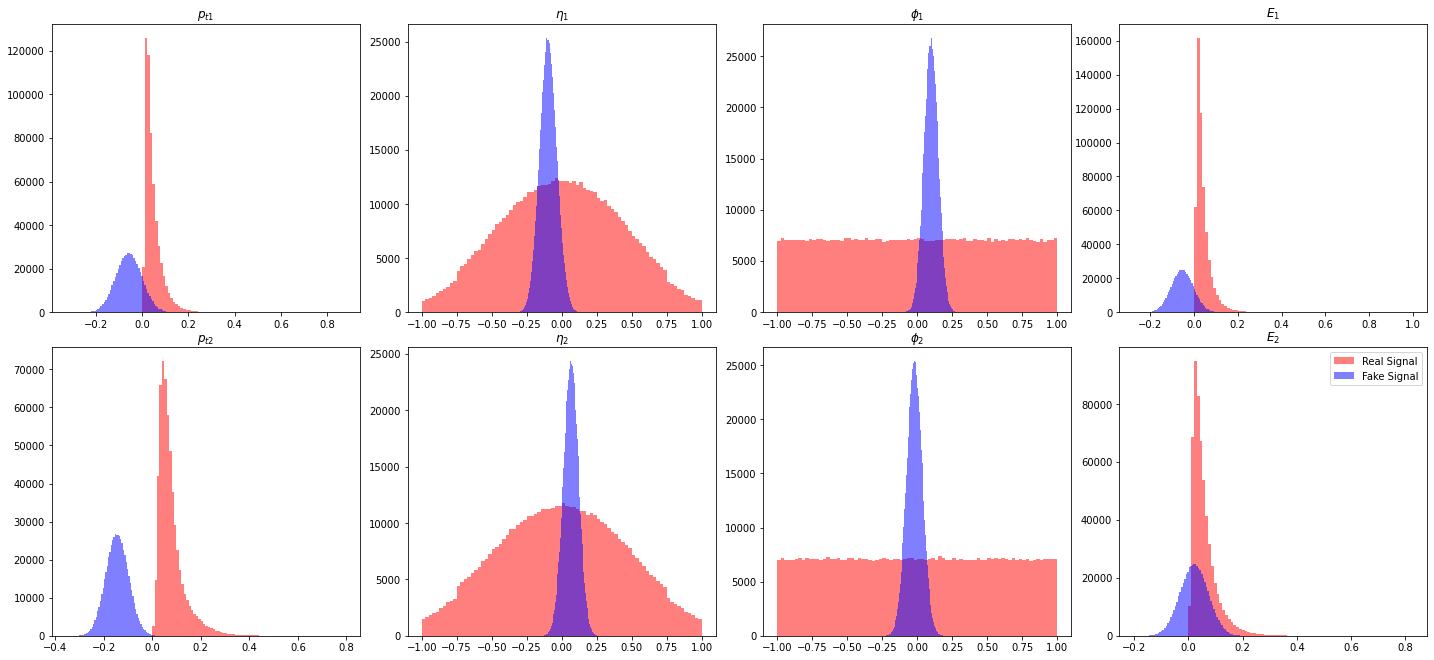

In [12]:
fig, ax = plt.subplots(2,4,figsize=(20, 10))
fig.tight_layout(pad=1.7)
plt.subplots_adjust(bottom=0.05, top=0.9)

features_name = ["$p_{t1}$","$\eta_{1}$","$\phi_{1}$","$E_{1}$","$p_{t2}$","$\eta_{2}$","$\phi_{2}$","$E_{2}$"]

for i in range(features_wanted):
    # real signal
    ax[int(i/4),i%4].hist(X_train[:,i],  alpha=0.5, color='r', label='Real Signal', bins=80)
    # fake signal
    ax[int(i/4),i%4].hist(fake_data[:,i],  alpha=0.5, color='b', label='Fake Signal', bins=80)

    ax[int(i/4),i%4].title.set_text(features_name[i])

plt.legend()
plt.show()

In [13]:
# This method returns a helper function to compute cross entropy and mse loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    return mse(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)

In [17]:
checkpoint_dir = '/content/drive/MyDrive/Projects/CERN openlab Summer Student 2021/classical model'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=model_gen,
                                 discriminator=model_disc)

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(features):
    noise = tf.random.uniform([len(features), 128], minval=0, maxval=1, seed=None)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_features = model_gen(noise, training=True)

      real_output = model_disc(features, training=True)
      fake_output = model_disc(generated_features, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, model_gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, model_disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, model_gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model_disc.trainable_variables))

    return gen_loss, disc_loss

In [19]:
def train(dataset, epochs):
    
    # list container to record epoch losses
    gen_history = []
    disc_history = []

    # epoch/iteration loop
    for epoch in range(epochs):
      start = time.time()

      # list container to record the mini-batch losses
      gen_loss = []
      disc_loss = []

      # train the models in mini-batches (the mini-batches loop)
      for data_batch in dataset:
        gl, dl = train_step(data_batch)
        gen_loss += [gl]
        disc_loss += [dl]
      
      # average the mini-batch losses to get the epoch loss
      gen_loss_mean = np.mean(np.array(gen_loss))
      disc_loss_mean = np.mean(np.array(disc_loss))

      # record the epoch loss
      gen_history += [gen_loss_mean]
      disc_history += [disc_loss_mean]

      # Save the model and epoch losses every 20 epochs
      if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        np.savetxt(checkpoint_dir + '/gen_loss.txt', np.array(gen_history))
        np.savetxt(checkpoint_dir + '/disc_loss.txt', np.array(disc_history))

      print ('Time for epoch {} is {} sec. Generator loss: {}, Discriminator loss: {}.'.format(epoch + 1, time.time()-start, gen_loss_mean, disc_loss_mean))

    return gen_history, disc_history

In [20]:
# Batch and shuffle the data
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 8), types: tf.float64>

In [21]:
# Sanity check

i = 0
for data_batch in train_dataset:
  if i == 0:
    print(len(data_batch))
  i += 1

print(i)
print(len(X_train)/128)

128
4424
4423.7109375


# Model Training

Time for epoch 1 is 23.47862720489502 sec. Generator loss: 0.2905539572238922, Discriminator loss: 1.2541669607162476.
Time for epoch 2 is 21.674161195755005 sec. Generator loss: 0.47791343927383423, Discriminator loss: 0.8364001512527466.
Time for epoch 3 is 21.313791036605835 sec. Generator loss: 0.4711776673793793, Discriminator loss: 0.9475324153900146.
Time for epoch 4 is 21.46384072303772 sec. Generator loss: 0.3518698811531067, Discriminator loss: 1.2396247386932373.
Time for epoch 5 is 21.353013515472412 sec. Generator loss: 0.2779204845428467, Discriminator loss: 1.3507102727890015.
Time for epoch 6 is 21.5917227268219 sec. Generator loss: 0.2628212869167328, Discriminator loss: 1.3688822984695435.
Time for epoch 7 is 21.448522806167603 sec. Generator loss: 0.2606826424598694, Discriminator loss: 1.3704932928085327.
Time for epoch 8 is 21.662910223007202 sec. Generator loss: 0.26174306869506836, Discriminator loss: 1.3697450160980225.
Time for epoch 9 is 21.44789171218872 sec.

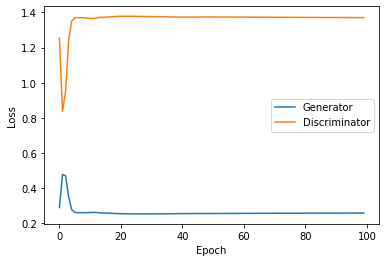

In [22]:
EPOCHS = 100
gen_history, disc_history = train(train_dataset, EPOCHS)

plt.plot(gen_history, label="Generator")
plt.plot(disc_history, label="Discriminator")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [23]:
input_vector = tf.random.uniform([len(X_train), 128], minval=0, maxval=1, seed=None)
input_vector.shape

TensorShape([566235, 128])

In [24]:
fake_data = model_gen.predict(input_vector)
fake_data.shape

(566235, 8)

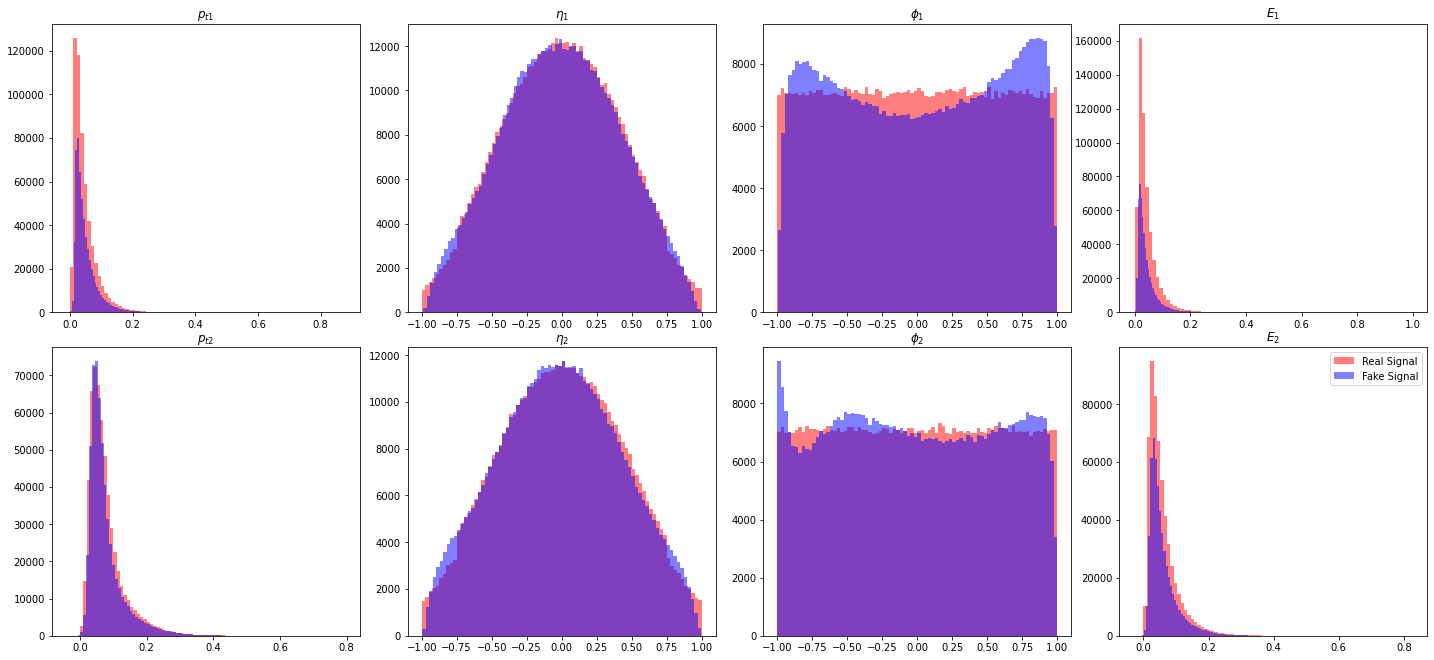

In [25]:
fig, ax = plt.subplots(2,4,figsize=(20, 10))
fig.tight_layout(pad=1.7)
plt.subplots_adjust(bottom=0.05, top=0.9)

features_name = ["$p_{t1}$","$\eta_{1}$","$\phi_{1}$","$E_{1}$","$p_{t2}$","$\eta_{2}$","$\phi_{2}$","$E_{2}$"]

for i in range(features_wanted):
    # real signal
    ax[int(i/4),i%4].hist(X_train[:,i],  alpha=0.5, color='r', label='Real Signal', bins=80)
    # fake signal
    ax[int(i/4),i%4].hist(fake_data[:,i],  alpha=0.5, color='b', label='Fake Signal', bins=80)

    ax[int(i/4),i%4].title.set_text(features_name[i])

plt.legend()
plt.show()